In [1]:
# Import necessary libraries
!pip install lazypredict
!pip install optuna-integration[xgboost]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import optuna
import warnings

# Sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, roc_auc_score, PrecisionRecallDisplay

# LazyPredict import
from lazypredict.Supervised import LazyClassifier

# Optuna integration imports
from optuna_integration.xgboost import XGBoostPruningCallback
from optuna_integration.lightgbm import LightGBMPruningCallback

# Filter warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.6/680.6 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.9 MB/s eta 0:00:00


In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')
original = pd.read_csv('/kaggle/input/bank-marketing-dataset-full/bank-full.csv', sep=';')

# Encode target column in original data
original['y'] = original['y'].map({'yes': 1.0, 'no': 0.0})

# Combine train and original data
train = pd.concat([train, original])
train.reset_index(drop=True, inplace=True)

# Add data type columns
train['data_type'] = 'train'
test['data_type'] = 'test'

In [3]:
# Data Preprocessing Functions
# Function to reduce memory usage
def reduce_mem_usage(df, verbose=True):
    mem_before = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage of dataframe is {mem_before:.2f} MB")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for col in df.columns:
            col_type = df[col].dtype

            if str(col_type)[:3] == 'int':
                c_min = df[col].min()
                c_max = df[col].max()
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            elif str(col_type)[:5] == 'float':
                c_min = df[col].min()
                c_max = df[col].max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)

    mem_after = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage after optimization is: {mem_after:.2f} MB")
        print(f"Decreased by {(100 * (mem_before - mem_after) / mem_before):.1f}%")

    return df

# Function to preprocess numerical columns
def preprocess_numerical_cols(df, numerical_cols):
    original_col_names = df.columns.tolist()

    for col in numerical_cols:
        lower_bound = df[col].quantile(0.005)
        upper_bound = df[col].quantile(0.995)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    df['duration_log'] = np.log1p(df['duration'])
    df['campaign_log'] = np.log1p(df['campaign'])
    df['pdays_log'] = np.log1p(df['pdays'] + 2)
    df['previous_log'] = np.log1p(df['previous'] + 1)

    new_numerical_cols = ['duration_log', 'campaign_log', 'pdays_log', 'previous_log']

    drop_cols = set()
    for new_cols in new_numerical_cols:
        for num_cols in numerical_cols:
            correlation = df[num_cols].corr(df[new_cols])
            if correlation >= 0.90 or correlation <= -0.90:
                print(f"There is high correlation - {correlation:.2f} between {num_cols} and {new_cols}. {new_cols} has been dropped to avoid multicollinearity!")
                drop_cols.add(new_cols)

    drop_cols = ['id'] + list(drop_cols)

    return df[[col for col in df.columns if col not in drop_cols]]

# Function to preprocess categorical columns
def preprocess_categorical_cols(df, cat_cols, encoder_type='onehot'):
    if df is None:
        raise ValueError("Input DataFrame for categorical preprocessing is None. Please check the return value of the preceding function.")

    if encoder_type == 'onehot':
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    elif encoder_type == 'ordinal':
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    else:
        raise ValueError("Invalid encoder_type. Choose 'onehot' or 'ordinal'.")

    encoded_cols = encoder.fit_transform(df[cat_cols])
    feature_names = encoder.get_feature_names_out(cat_cols)
    encoded_df = pd.DataFrame(encoded_cols, columns=feature_names, index=df.index)
    remainder_cols = df.drop(columns=cat_cols)
    processed_df = pd.concat([encoded_df, remainder_cols], axis=1)

    return processed_df

In [4]:
# Data Preprocessing
# Define numerical and categorical columns
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Apply standard scaler
for col in numerical_cols:
    sc = MinMaxScaler()
    train[col] = sc.fit_transform(train[[col]])
    test[col] = sc.transform(test[[col]])

# Combine train and test data
data = pd.concat([train, test])

# Preprocess categorical columns
data_processed = preprocess_categorical_cols(data, cat_cols, encoder_type='ordinal')

# Split back into train and test
train = data_processed[data_processed['data_type'] == 'train'].drop(columns=['data_type', 'id'])
test = data_processed[data_processed['data_type'] == 'test'].drop(columns=['data_type', 'id', 'y'])

# Reduce memory usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 109.21 MB
Memory usage after optimization is: 31.85 MB
Decreased by 70.8%
Memory usage of dataframe is 32.42 MB
Memory usage after optimization is: 9.54 MB
Decreased by 70.6%


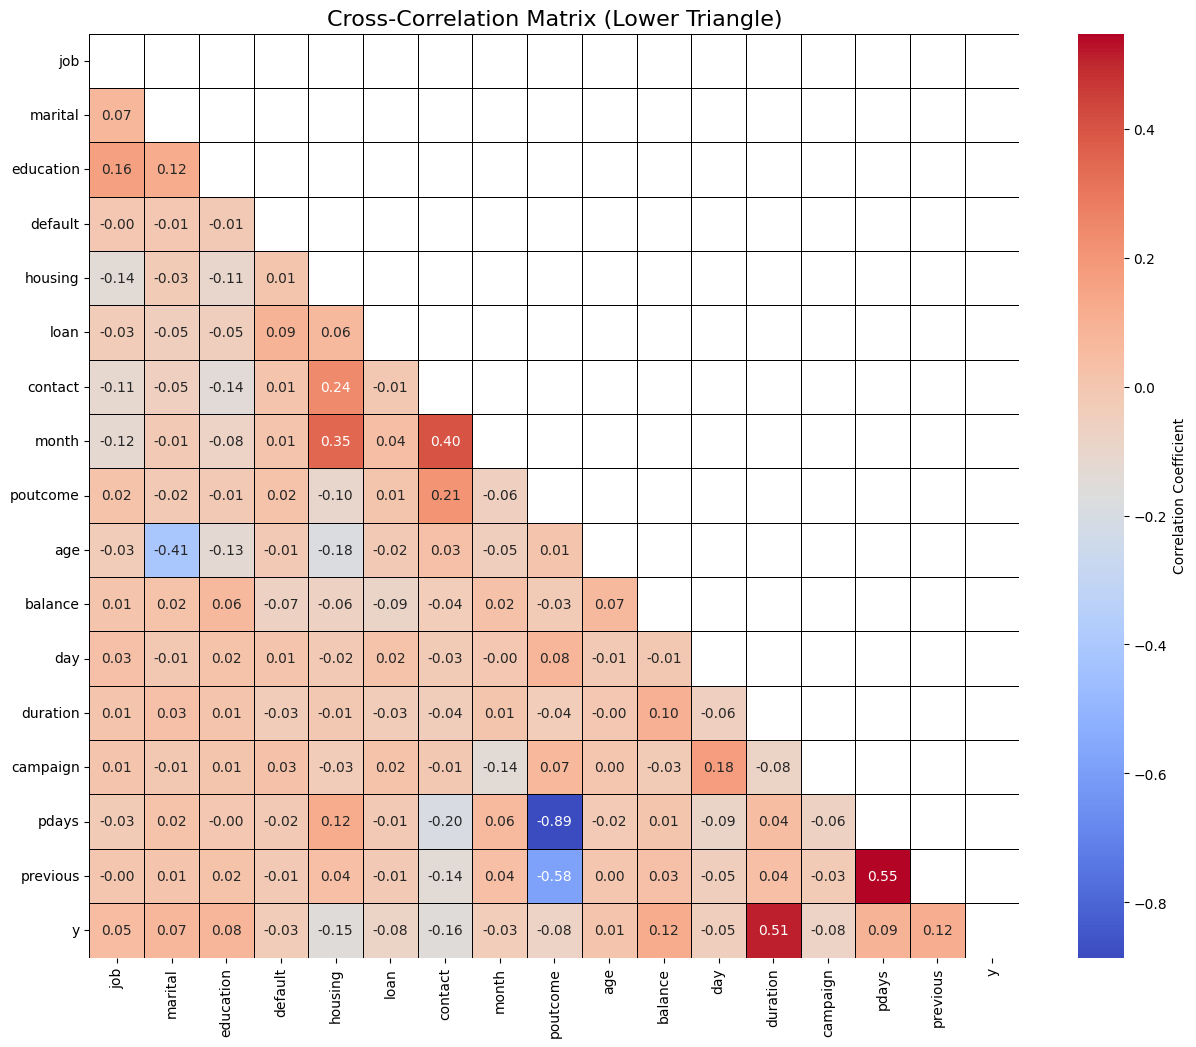

In [5]:
# Data Visualization
# Features and target
X = train.drop(columns='y')
y = train.y

# Correlation matrix
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Cross-Correlation Matrix (Lower Triangle)', fontsize=16)
plt.show()

In [6]:
# Model Training and Evaluation
# Define constants
SEED = 42
optimize_xgb = False

# Objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'n_jobs': -1,
        'random_state': SEED,
        'n_estimators': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 1e2, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 1, 3),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1e-2, 1e2, log=True)
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    cv_loglosses = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        pruning_callback = XGBoostPruningCallback(trial, "validation_0-logloss")

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose=False,
            callbacks=[pruning_callback]
        )

        val_preds = model.predict_proba(X_val)[:, 1]
        fold_logloss = log_loss(y_val, val_preds)
        cv_loglosses.append(fold_logloss)

    return np.mean(cv_loglosses)

# Optuna study
if optimize_xgb:
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    study.optimize(objective, n_trials=200)

# Best parameters
if optimize_xgb:
    print("Best Parameters:")
    best_xgb_params = study.best_params
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"Best Log Loss: {study.best_value:.4f}")
else:
    best_xgb_params = {
        'learning_rate': 0.256267492623029,
        'max_depth': 9,
        'subsample': 0.827331966551961,
        'colsample_bytree': 0.5162387128904999,
        'min_child_weight': 3.030267595188744,
        'gamma': 4.33182316377124e-06,
        'reg_alpha': 0.7631464924169871,
        'reg_lambda': 0.0010681529627022167,
        'num_parallel_tree': 3,
        'scale_pos_weight': 0.9386836476714302,
    }

# Define models
lgb_params = {
    'learning_rate': 0.06,
    'max_depth': 7,
    'num_leaves': 100,
    'max_bin': 255,
    'subsample': 0.82,
    'colsample_bytree': 0.65,
    'subsample_freq': 1,
    'reg_alpha': 0.81,
    'reg_lambda': 2.1,
    'min_child_samples': 25,
    'min_split_gain': 0.005,
    'extra_trees': True,
    'bagging_seed': SEED,
    'feature_fraction_seed': SEED,
    'n_estimators': 20000,
}

model_lgb = lgb.LGBMClassifier(
    max_depth=6,
    n_estimators=20000,
    learning_rate=0.06,
    reg_alpha=0.8,
    reg_lambda=3.0,
    colsample_bytree=0.5,
    subsample=0.8,
    max_bin=4523,
    n_jobs=-1,
    random_state=SEED,
    verbose=-1,
)

model_xgb = xgb.XGBClassifier(
    **best_xgb_params,
    n_estimators=20000,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_jobs=-1,
    random_state=SEED,
)

In [7]:
# Cross-Validation and Blending
# Cross-validation setup
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Out-of-fold predictions
oof_lgb = np.zeros(X.shape[0])
oof_xgb = np.zeros(X.shape[0])

# Test predictions
lgb_preds = np.zeros(test.shape[0])
xgb_preds = np.zeros(test.shape[0])

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nTraining fold {fold + 1}/{n_splits}")

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Train LightGBM
    print("  - Training LightGBM...")
    model_lgb.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(period=100)]
    )

    oof_lgb[val_idx] = model_lgb.predict_proba(X_val)[:, 1]
    lgb_preds += model_lgb.predict_proba(test)[:, 1] / n_splits
    print(f"  - LightGBM Fold {fold + 1} validation log loss: {log_loss(y_val, oof_lgb[val_idx]):.4f}")

    # Train XGBoost
    print("  - Training XGBoost...")
    model_xgb.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=1000
    )

    oof_xgb[val_idx] = model_xgb.predict_proba(X_val)[:, 1]
    xgb_preds += model_xgb.predict_proba(test)[:, 1] / n_splits
    print(f"  - XGBoost Fold {fold + 1} validation log loss: {log_loss(y_val, oof_xgb[val_idx]):.4f}")


Training fold 1/10
  - Training LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.166664
[200]	valid_0's binary_logloss: 0.155586
[300]	valid_0's binary_logloss: 0.151385
[400]	valid_0's binary_logloss: 0.148688
[500]	valid_0's binary_logloss: 0.147041
[600]	valid_0's binary_logloss: 0.1456
[700]	valid_0's binary_logloss: 0.144317
[800]	valid_0's binary_logloss: 0.143362
[900]	valid_0's binary_logloss: 0.142508
[1000]	valid_0's binary_logloss: 0.141749
[1100]	valid_0's binary_logloss: 0.141153
[1200]	valid_0's binary_logloss: 0.140584
[1300]	valid_0's binary_logloss: 0.139988
[1400]	valid_0's binary_logloss: 0.13957
[1500]	valid_0's binary_logloss: 0.139172
[1600]	valid_0's binary_logloss: 0.138847
[1700]	valid_0's binary_logloss: 0.138529
[1800]	valid_0's binary_logloss: 0.138228
[1900]	valid_0's binary_logloss: 0.137977
[2000]	valid_0's binary_logloss: 0.137685
[2100]	valid_0's binary_logloss: 0.137415
[2200]	valid_0's binary

In [8]:
# Blending and Submission
# Blending weights
best_logloss, best_logloss_weight = float('inf'), 0.0
best_roc_auc, best_roc_weight = float('-inf'), 0.0

weights = np.linspace(0.0, 1.0, 101)

for w in weights:
    blended_oof = w * oof_xgb + (1 - w) * oof_lgb

    current_logloss = log_loss(y, blended_oof)
    current_roc_auc = roc_auc_score(y, blended_oof)

    if current_logloss < best_logloss:
        best_logloss = current_logloss
        best_logloss_weight = w

    if current_roc_auc > best_roc_auc:
        best_roc_auc = current_roc_auc
        best_roc_weight = w

print(f"Best LogLoss blending weight (XGB): {best_logloss_weight:.2f}")
print(f"Best LogLoss blending weight (LGB): {1 - best_logloss_weight:.2f}")
print(f"Blended OOF LogLoss: {best_logloss:.4f}")
print()
print(f"Best ROC AUC blending weight (XGB): {best_roc_weight:.2f}")
print(f"Best ROC AUC blending weight (LGB): {1 - best_roc_weight:.2f}")
print(f"Blended OOF ROC AUC: {best_roc_auc:.4f}")

# Final predictions
final_preds = best_logloss_weight * xgb_preds + (1 - best_logloss_weight) * lgb_preds

# Save submission
submission['y'] = final_preds
submission.to_csv('submission.csv', index=False)
print(submission.head(15))

Best LogLoss blending weight (XGB): 0.01
Best LogLoss blending weight (LGB): 0.99
Blended OOF LogLoss: 0.1365

Best ROC AUC blending weight (XGB): 0.01
Best ROC AUC blending weight (LGB): 0.99
Blended OOF ROC AUC: 0.9717
        id    y
0   750000 0.00
1   750001 0.11
2   750002 0.00
3   750003 0.00
4   750004 0.02
5   750005 0.00
6   750006 0.42
7   750007 0.53
8   750008 0.01
9   750009 0.26
10  750010 0.00
11  750011 0.01
12  750012 0.30
13  750013 0.00
14  750014 0.17
